# II. Prédiction de la consommation totale d'énergie

## Importation des modules python

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sidetable

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,Normalizer,OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.svm import LinearSVR, SVR
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor

In [2]:
# Import the dataset with ENERGYSTARScore
seattle_data = pd.read_csv("with_energystarscore.csv")
seattle_data.sample(5)

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
502,1.0,4,165111,55000,110111,104667.0,1.0,231.399994,231.399994,726.599976,726.599976,2.547809e+07,2.547809e+07,0.0,7.467199e+06,25478083.0,0.000000,0.0,177.62,1.08
225,1.0,63,1354987,159600,1195387,1191115.0,89.0,50.400002,50.400002,158.100006,158.100006,6.157618e+07,6.157618e+07,0.0,1.804695e+07,61576180.0,0.000000,0.0,429.27,0.32
1424,1.0,1,29400,0,29400,25000.0,69.0,9.100000,9.100000,28.600000,28.600000,2.275095e+05,2.275095e+05,0.0,6.667920e+04,227509.0,0.000000,0.0,1.59,0.05
1397,1.0,1,24200,0,24200,24200.0,73.0,34.200001,37.200001,76.099998,79.400002,8.264887e+05,9.006971e+05,0.0,1.366749e+05,466335.0,3601.539795,360154.0,22.38,0.92
1147,1.0,1,36544,0,36544,36544.0,5.0,34.700001,36.599998,109.099998,115.000000,1.269848e+06,1.338476e+06,0.0,3.721710e+05,1269847.0,0.000000,0.0,8.85,0.24


In [3]:
seattle_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1693 entries, 0 to 1692
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   NumberofBuildings          1693 non-null   float64
 1   NumberofFloors             1693 non-null   int64  
 2   PropertyGFATotal           1693 non-null   int64  
 3   PropertyGFAParking         1693 non-null   int64  
 4   PropertyGFABuilding(s)     1693 non-null   int64  
 5   LargestPropertyUseTypeGFA  1693 non-null   float64
 6   ENERGYSTARScore            1693 non-null   float64
 7   SiteEUI(kBtu/sf)           1693 non-null   float64
 8   SiteEUIWN(kBtu/sf)         1693 non-null   float64
 9   SourceEUI(kBtu/sf)         1693 non-null   float64
 10  SourceEUIWN(kBtu/sf)       1693 non-null   float64
 11  SiteEnergyUse(kBtu)        1693 non-null   float64
 12  SiteEnergyUseWN(kBtu)      1693 non-null   float64
 13  SteamUse(kBtu)             1693 non-null   float

### Mise en échelle des variables 

In [4]:
# Standard scaling the predictor columns
# scale features
seattle_data_model = seattle_data.copy()
scaler = StandardScaler()
seattle_data_model.loc[:,seattle_data_model.select_dtypes(include=[np.number]).columns.tolist()] = scaler.fit_transform(seattle_data_model.loc[:,seattle_data_model.select_dtypes(include=[np.number]).columns.tolist()])

### Variables d'entrainement et variables cibles

In [5]:
# Energy dataset without transformation of SiteEnergyUse(kBtu) target
seattle_energy_target = pd.DataFrame(np.log1p(seattle_data_model["SiteEnergyUse(kBtu)"]))
seattle_energy_predictors = seattle_data_model.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions',
                                                       "SiteEnergyUseWN(kBtu)","GHGEmissionsIntensity"], axis=1)

In [6]:
seattle_energy_target

,SiteEnergyUse(kBtu)
0,-0.040922
1,-0.001393
2,1.143490
3,-0.056023
4,0.175088
...,...
1688,-0.291104
1689,-0.286633
1690,-0.092947
1691,-0.296929


### train/test split

In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(seattle_energy_predictors, seattle_energy_target, test_size=0.2,
                                                    random_state=33)
print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_test',X_test.shape)
print('y_test',y_test.shape)

X_train (1354, 16)
y_train (1354, 1)
X_test (339, 16)
y_test (339, 1)


### Regression linéaire

In [8]:
# Regression object
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [10]:
# Prediction score(coefficient of determination of the model)
r2_score_lin = lin_model.score(X_test, y_test)
print(f"The coefficient of determination of the model is : {r2_score}") 

The coefficient of determination of the model is : 0.5566206152678895


In [11]:
# Predicted values
y_pred = lin_model.predict(X_test)

# RMSE est une mesure relative qui va dépendre de la valeur de la variable cible. Obtenir 2 RMSE différentes pour 2 sets 
    # de données et donc pour 2 modèles différents ne permet pas de conclure.
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_lin

0.2144204483277361

In [12]:
# MAPE est une mesure relative mais indépendante de l'amplitude de la variable cible, donc une MAPE plus petite veut bien
 # dire un meilleur modèle.
mape_lin = mean_absolute_percentage_error(y_test, y_pred)
mape_lin

1.1396790834389443

Text(0.5, 1.0, 'Ajustement du modèle LinearRegression')

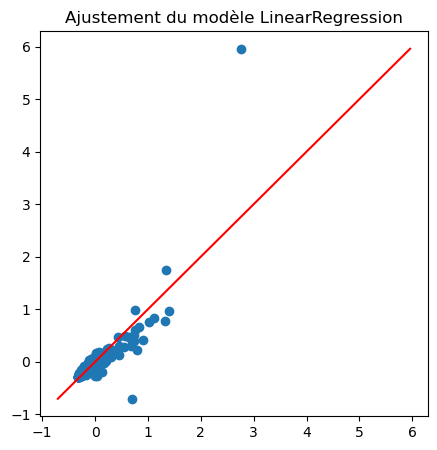

In [13]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
xmax = max(max(y_pred), max(np.array(y_test)))
xmin = min(min(y_pred), min(np.array(y_test)))
plt.plot([xmax, xmin], [xmax, xmin],'r')
plt.title(f"Ajustement du modèle {type(lin_model).__name__}")

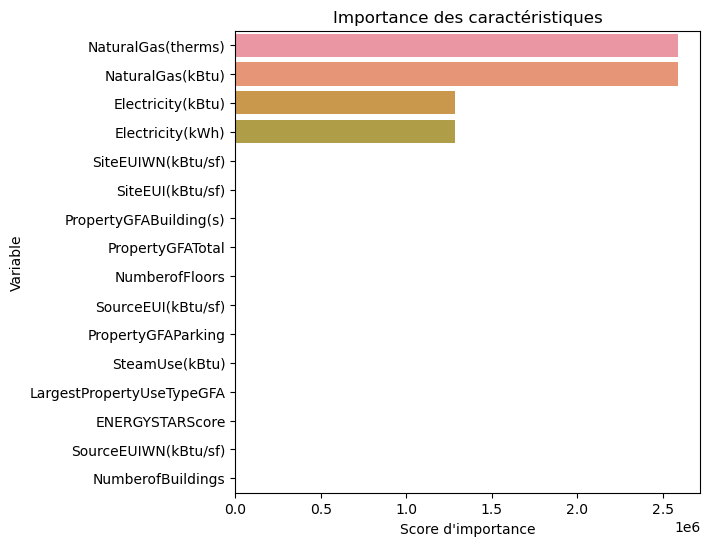

In [14]:
# perform permutation importance and get importance
importance_scores = permutation_importance(lin_model, X_test, y_test, scoring='neg_mean_absolute_percentage_error').importances_mean

# Feature importance plot

feature_importance_dict = {}
feature_importance_dict["Variable"] = []
feature_importance_dict["Score d'importance"] = []

for column,score in zip(X_train.columns,importance_scores):
    feature_importance_dict["Variable"].append(column)
    feature_importance_dict["Score d'importance"].append(score)

model_feature_importance = pd.DataFrame(feature_importance_dict).sort_values(by="Score d'importance",ascending=False)


plt.figure(figsize=(6,6))
plt.title("Importance des caractéristiques")
sns.barplot(y = model_feature_importance["Variable"],x=model_feature_importance["Score d'importance"])
plt.show()

### Gridsearch avec la classe RandomForestRegressor

In [15]:
# Set of parameters
params = {
    # Number of trees decision
    'n_estimators' : [10,50,100,150,200], 
    # Minimum number of leaves in a node
    'min_samples_leaf' : [1,3,5,10], 
    # number of features observed for each tree
    'max_features': ['auto', 'sqrt'] 
}

# GridSearchCV class with RandomForestRegressor
grid_rf=GridSearchCV(RandomForestRegressor(),param_grid=params,cv=5)

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 150, 200]})

In [16]:
# R^2 score : The accurency of the model
r2_rf = grid_rf.score(X_test, y_test)
r2_rf

0.9582307848413165

In [17]:
# Predicted values
y_pred = grid_rf.predict(X_test)
# RMSE est une mesure relative qui va dépendre de la valeur de la variable cible. Obtenir 2 RMSE différentes pour 2 sets 
    # de données et donc pour 2 modèles différents ne permet pas de conclure.
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_rf

0.06581223033665046

In [18]:
# MAPE est une mesure relative mais indépendante de l'amplitude de la variable cible, donc une MAPE plus petite veut bien
 # dire un meilleur modèle.
mape_rf = mean_absolute_percentage_error(y_test, y_pred)
mape_rf

0.19105833100690361

Text(0.5, 1.0, 'Ajustement du modèle GridSearchCV')

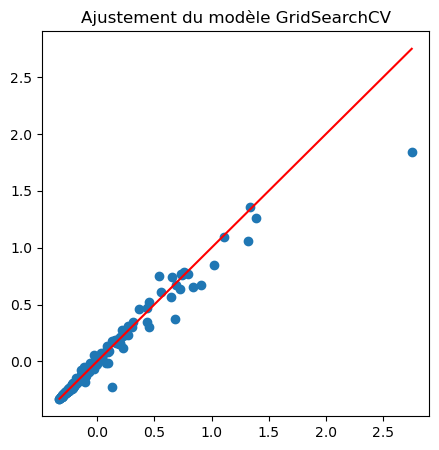

In [19]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
xmax = max(max(y_pred), max(np.array(y_test)))
xmin = min(min(y_pred), min(np.array(y_test)))
plt.plot([xmax, xmin], [xmax, xmin],'r')
plt.title(f"Ajustement du modèle {type(grid_rf).__name__}")

In [20]:
# Best estimator
grid_rf.best_estimator_

RandomForestRegressor(max_features='sqrt', n_estimators=200)

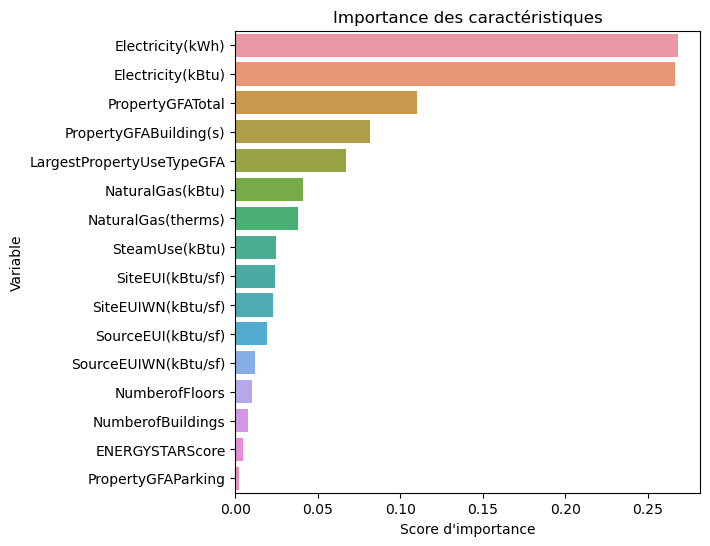

In [21]:
# Feature importance plot

feature_importance_dict = {}
feature_importance_dict["Variable"] = []
feature_importance_dict["Score d'importance"] = []

for column,score in zip(X_train.columns,grid_rf.best_estimator_.feature_importances_):
    feature_importance_dict["Variable"].append(column)
    feature_importance_dict["Score d'importance"].append(score)

rf_feature_importance = pd.DataFrame(feature_importance_dict).sort_values(by="Score d'importance",ascending=False)

# Plot feature imporrtance
plt.figure(figsize=(6,6))
plt.title("Importance des caractéristiques")
sns.barplot(y = rf_feature_importance["Variable"],x=rf_feature_importance["Score d'importance"])
plt.show()

- Nous remarquons que les informations sur la consommation en électricité ont plus d'influence sur notre modèle de prédiction de la consommation en energie. Il n'empêche que les autres caractéristiques d'énergie semblent influer sur le modèle.
- Les caractéristiques sur la surface totale notamment la superficie totale du bâtiment et du parking sont aussi influents sur le modèle. 
- La variable ENERGYSTARScore qui évalue la performance énergétique globale d'une propriété n'est pas très influent dans ce modèle. 

### Gridsearch avec Support Vector Machine

In [22]:
# Set of parameters
params={
    # kernel coefficient 
    "gamma" : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 
    # error tolerated by the algorithm
    "epsilon" : [0.001, 0.01, 0.1, 1], 
    # Regularization parameter
    "C" : [0.001, 0.01, 0.1, 1, 10]
}

svm_model = GridSearchCV(estimator=SVR(),param_grid=params,cv=5)

svm_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'epsilon': [0.001, 0.01, 0.1, 1],
                         'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1]})

In [23]:
# The coefficient of determination of the prediction.
r2_svr = svm_model.score(X_test,y_test)
r2_svr

0.8847545288007186

In [24]:
# make predictions on the data 
y_pred = svm_model.predict(X_test)

# RMSE est une mesure relative qui va dépendre de la valeur de la variable cible. Obtenir 2 RMSE différentes pour 2 sets 
    # de données et donc pour 2 modèles différents ne permet pas de conclure.
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_svr

0.10931767477022847

In [25]:
# MAPE est une mesure relative mais indépendante de l'amplitude de la variable cible, donc une MAPE plus petite veut bien
 # dire un meilleur modèle.
mape_svr = mean_absolute_percentage_error(y_test, y_pred)
mape_svr

0.1338315581903506

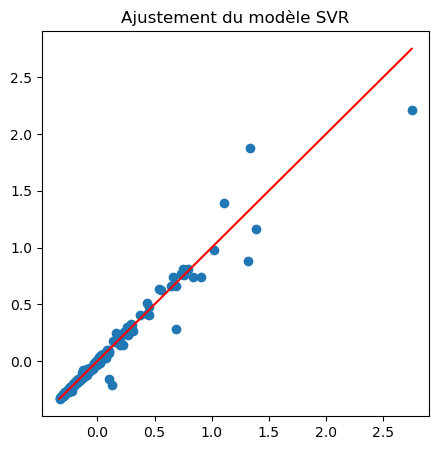

In [54]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
xmax = max(max(y_pred), float(max(np.array(y_test))))
xmin = min(min(y_pred), float(min(np.array(y_test))))
plt.plot([xmin, xmax], [xmin, xmax],'r')
plt.title(f"Ajustement du modèle {type(svm_model.best_estimator_).__name__}")
plt.show()

In [27]:
# Best estimator
svm_model.best_estimator_

SVR(C=10, epsilon=0.01, gamma=0.01)

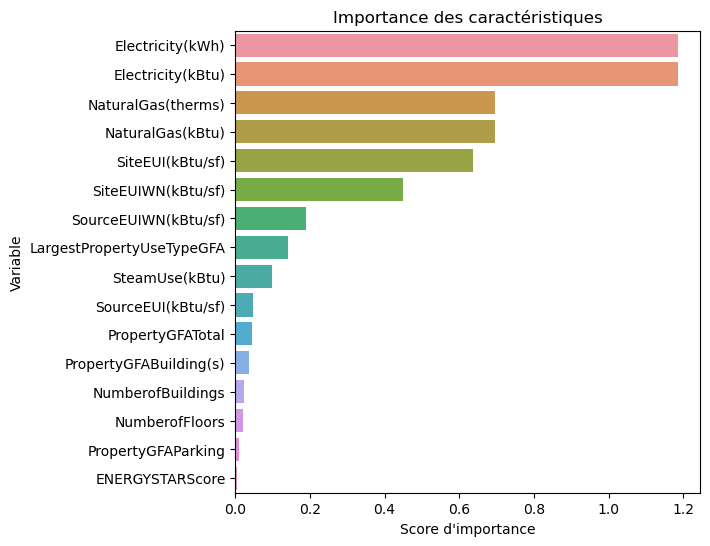

In [28]:
# perform permutation importance and get importance
importance_scores = permutation_importance(svm_model, X_test, y_test, scoring='neg_mean_absolute_percentage_error').importances_mean

# Feature importance plot

feature_importance_dict = {}
feature_importance_dict["Variable"] = []
feature_importance_dict["Score d'importance"] = []

for column,score in zip(X_train.columns,importance_scores):
    feature_importance_dict["Variable"].append(column)
    feature_importance_dict["Score d'importance"].append(score)

model_feature_importance = pd.DataFrame(feature_importance_dict).sort_values(by="Score d'importance",ascending=False)


plt.figure(figsize=(6,6))
plt.title("Importance des caractéristiques")
sns.barplot(y = model_feature_importance["Variable"],x=model_feature_importance["Score d'importance"])
plt.show()

###  Xgboost

In [29]:
params = {'n_estimators' : [100,200,300,400,500,600,700]}
boosting_model = GridSearchCV(XGBRegressor(),param_grid=params,cv=5)
boosting_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'n_estimators': [100, 200, 300, 400, 500, 600, 700]})

In [30]:
# The coefficient of determination of the prediction.
r2_xgb = boosting_model.score(X_test,y_test)
r2_xgb

0.9606340294318376

In [31]:
# make predictions on the data 
y_pred = boosting_model.predict(X_test)

# RMSE est une mesure relative qui va dépendre de la valeur de la variable cible. Obtenir 2 RMSE différentes pour 2 sets 
    # de données et donc pour 2 modèles différents ne permet pas de conclure.
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_xgb

0.06389088931827543

In [32]:
# MAPE est une mesure relative mais indépendante de l'amplitude de la variable cible, donc une MAPE plus petite veut bien
 # dire un meilleur modèle.
mape_xgb = mean_absolute_percentage_error(y_test, y_pred)
mape_xgb

0.1503428403086635

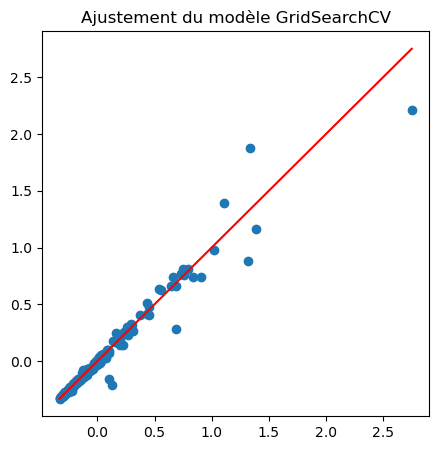

In [33]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
xmax = max(max(y_pred), float(max(np.array(y_test))))
xmin = min(min(y_pred), float(min(np.array(y_test))))
plt.plot([xmin, xmax], [xmin, xmax],'r')
plt.title(f"Ajustement du modèle {type(boosting_model).__name__}")
plt.show()

In [34]:
# Best estimator
boosting_model.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

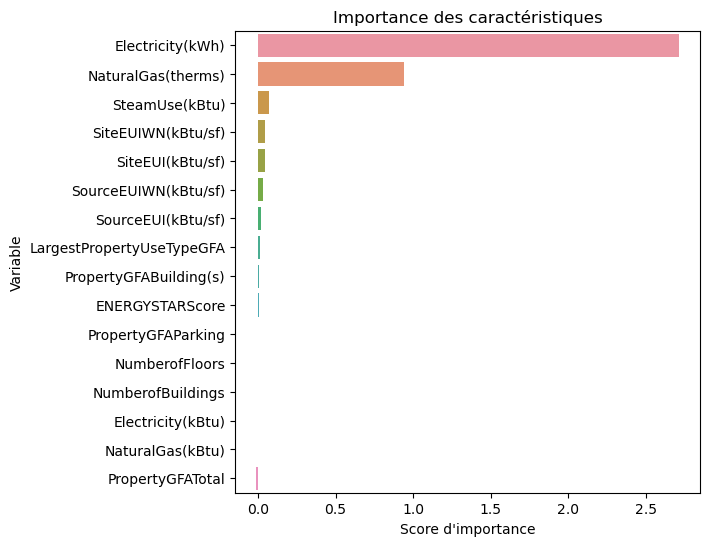

In [35]:
# perform permutation importance with permutation_importance class
importance_scores = permutation_importance(boosting_model, X_test, y_test, scoring='neg_mean_absolute_percentage_error').importances_mean

# Feature importance plot

feature_importance_dict = {}
feature_importance_dict["Variable"] = []
feature_importance_dict["Score d'importance"] = []

for column,score in zip(X_train.columns,importance_scores):
    feature_importance_dict["Variable"].append(column)
    feature_importance_dict["Score d'importance"].append(score)

model_feature_importance = pd.DataFrame(feature_importance_dict).sort_values(by="Score d'importance",ascending=False)


plt.figure(figsize=(6,6))
plt.title("Importance des caractéristiques")
sns.barplot(y = model_feature_importance["Variable"],x=model_feature_importance["Score d'importance"])
plt.show()

# Interprétation des résultats

In [50]:
# Metrics 
lin_list = [r2_score_lin,rmse_lin,mape_lin]
rf_list = [r2_rf,rmse_rf,mape_rf]
svr_list = [r2_svr,rmse_svr,mape_svr]
xgb_list = [r2_xgb,rmse_xgb,mape_xgb]
tableau = np.array([lin_list,rf_list,svr_list,xgb_list])
model_liste = [type(lin_model).__name__,type(grid_rf.best_estimator_).__name__,
               type(svm_model.best_estimator_).__name__,type(boosting_model.best_estimator_).__name__]

pd.DataFrame(tableau,model_liste,columns=["R2 Scores","RMSE","MAPE"]).sort_values(by="MAPE")

,R2 Scores,RMSE,MAPE
SVR,0.884755,0.109318,0.133832
XGBRegressor,0.960634,0.063891,0.150343
RandomForestRegressor,0.958231,0.065812,0.191058
LinearRegression,0.556621,0.214420,1.139679


- Presque tous les modèles ont de très bons scores de prédiction si l'on se réfère à leurs coefficients de détermination. Ils prédisent tous assez fidèlement la consommation totale d'énergie.
- La MAPE(mean absolute pourcentage error) reste cependant la meilleure métrique pour comparer la performance de ces modèles entre-eux. Une MAPE plus petite signifie que len modéle est le plus performant.
<br>

**Conclusion** :
> Nous avons donc le modèle de la régression par vecteur de support(SVR) comme notre modèle le plus performant pour la prédiction de la consommation totale d'énergie.